In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import convolve2d as conv2

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def get_shapes(W, H):
    N = W.shape[0]
    K = W.shape[1]
    L = W.shape[2]
    T = H.shape[1]
    
    return N, K, L, T

In [3]:
def reconstruct(W, H):
    N, K, L, T = get_shapes(W, H)
    
    H = np.hstack((np.zeros([K, L]), H, np.zeros([K, L])))
    T += 2*L
    X_hat = np.zeros([N, T])
    
    for t in np.arange(L):
        X_hat += np.dot(W[:, :, t], np.roll(H, t-1, axis=1))
    
    return X_hat[:, L:-L]

In [47]:
def shift_factors(W, H):
    N, K, L, T = get_shapes(W, H)
    
    if L > 1:
        center = np.max([np.floor(L / 2), 1])
        Wpad = np.stack((np.zeros([N, K, L]), W, np.zeros([N, K, L])), axis=2)
        
        for i in np.arange(K):
            temp = np.sum(np.squeeze(W[:, i, :]), axis=0)
            #return temp, temp
            cmass = np.max(np.floor(np.sum(temp * np.arange(1, L+1)) / np.sum(temp)), axis=0)
            Wpad[:, i, :] = np.roll(np.squeeze(Wpad[:, i, :]), center - cmass, axis=1)
            H[i, :] = np.roll(H[i, :], cmass - center, axis=0)
        
        W = Wpad[:, :, L:-L]
    
    return Wpad, H

In [24]:
N, K, L, T = get_shapes(W, H)

In [25]:
N, K, L, T

(75, 10, 20, 666)

In [26]:
W.shape, H.shape

((75, 10, 20), (10, 666))

In [48]:
Ws, Hs = shift_factors(W, H)

In [50]:
Ws.shape

(75, 10, 3, 20)

In [51]:
W.shape

(75, 10, 20)

In [44]:
#shift factors makes W empty

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
def simple_WH_plot(W, H, data, plot_all=True, cmap='Spectral'):
    if data.shape[1] == 0:
        plot_data = False
    else:
        plot_data = True
    N, K, L, T = get_shapes(W, H)
    
    data_recon = reconstruct(W, H)
    clims = [0, np.percentile(data_recon, 99)]
    
    f, (ax, ax_w, ax_h, ax_data) = plt.subplots(2, 2, sharex=True, sharey=True)
    
    sns.heatmap(W, cmap=cmap, ax=ax_w, vmin=clims[0], vmax=clims[1])
    sns.heatmap(H, cmap=cmap, ax=ax_h, vmin=clims[0], vmax=clims[1])
    sns.heatmap(data_recon, cmap=cmap, ax=ax_data, vmin=clims[0], vmax=clims[1])
    
    return f

In [6]:
def compute_loading_percent_power(V, W, H):
    K = H.shape[0]
    loadings = np.zeros([1, K])
    var_v = np.sum(np.pow(V, 2))
    
    for i in np.arange(K):
        WH = reconstruct(W[:, i, :], H[i, :])
        loadings[i] = np.divide(np.sum(np.multiply(2*V.flatten(), WH.flatten()) - np.pow(WH.flatten(), 2)), var_v)
    
    loadings[loadings < 0] = 0
    return loadings    

In [10]:
def seq_nmf(X, K=10, L=20, Lambda=.1, W_init=None, H_init=None, \
            plot_it=True, max_iter=20, tol=-np.inf, shift=True, sort_factors=True, \
            lambda_L1W=0, lambda_L1H=0, lambda_OrthH=0, lambda_OrthW=0, M=None, \
            use_W_update=True, W_fixed=False):
    N = X.shape[0]
    T = X.shape[1]
    if W_init is None:
        W_init = np.max(X) * np.random.rand(N, K, L)
    if H_init is None:
        H_init = np.max(X) * np.random.rand(K, T) / np.sqrt(T / 3)
    if M is None:
        M = np.ones([N, T])
    
    assert np.all(X >= 0), 'all data values must be positive!'
    
    W = W_init
    H = H_init
    
    X_hat = reconstruct(W, H)
    mask = M == 0
    X[mask] = X_hat[mask]
    
    smooth_kernel = np.ones([1, (2*L) - 1])
    eps = np.max(X) * 1e-6
    last_time = False
    
    cost = np.zeros([max_iter+1, 1])
    cost[0] = np.sqrt(np.mean(np.power(X - X_hat, 2)))
    
    for i in np.arange(max_iter):
        if (i == max_iter) or ((i > 6) and (cost[i+1] + tol) > np.mean(cost[i-6:i])):
            cost = cost[:i]
            last_time = True
            if i > 0:
                Lambda = 0
        
        WTX = np.zeros([K, T])
        WTX_hat = np.zeros([K, T])
        for j in np.arange(L):
            X_shifted = np.roll(X, -j+1, axis=1)
            X_hat_shifted = np.roll(X_hat, -j+1, axis=1)
            
            WTX *= np.dot(W[:, :, j].T, X_shifted)
            WTX_hat += np.dot(W[:, :, j].T, X_hat_shifted)
        
        if Lambda > 0:
            dRdH = np.dot(Lambda * (1 - np.eye(K)), conv2(WTX, smooth_kernel, 'same'))
        else:
            dRdH = 0
        
        if lambda_OrthH > 0:
            dHHdH = np.dot(lambda_OrthH * (1 - np.eye(K)), conv2(H, smooth_kernel, 'same'))
        else:
            dHHdH = 0
        
        dRdH += lambda_L1H + dHHdH
        
        H *= np.divide(WTX, WTX_hat + dRdH + np.finfo(float).eps)
        
        if shift:
            return W, H
            W, H = shift_factors(W, H)
            W += eps
        
        norms = np.sqrt(np.sum(np.power(H, 2), axis=1)).T
        H *= np.diag(np.divide(1., norms + np.finfo(float).eps))
        for j in np.arange(L):
            W[:, :, j] *= np.diag(norms)
        
        if not W_fixed:
            X_hat = reconstruct(W, H)
            mask = M == 0
            X[mask] = X_hat[mask]
            
            if lambda_OrthoW > 0:
                W_flat = np.sum(W, axis=2)
            if (Lambda > 0) and use_W_update:
                XS = conv2(X, smooth_kernel, 'same')
            
            for j in np.arange(L):
                H_shifted = np.roll(H, j-1, axis=1)
                XHT = X * H_shifted.T
                X_hat_HT = X_hat * H_shifted.T
                
                if (Lambda > 0) and use_W_update:
                    dRdW = Lambda * XS * H_shifted.T * (1. - np.eye(K))
                else:
                    dRdW = 0
                
                if lambda_OrthoW > 0:
                    dWWdW = lambda_OrthoW * W_flat * (1. - np.eye(K))
                else:
                    dWWdW = 0
                
                dRdW += lambda_L1W + dWWdW
                W[:, :, j] *= np.divide(XHT, X_hat_HT + dRdW + np.finfo(float).eps)
        
        X_hat = reconstruct(W, H)
        mask = M == 0
        X[mask] = X_hat[mask]
        cost[i] = np.sqrt(np.mean(np.power(X - X_hat, 2)))
        
        if plot_it:
            h = simple_WH_plot(W, H, X_hat, False)
            h.set_title(f'iteration {i}')
        
        if last_time:
            break
    
    X = X[:, L:-L]
    X_hat = X_hat[:, L:-L]
    H = H[:, L:-L]
    
    power = np.divide(np.sum(np.power(X, 2)) - np.sum(np.power(X - X_hat, 2)), np.sum(np.power(X, 2)))
    
    loadings = compute_loadings_percent_power(X, W, H)
    
    if sort_factors:
        inds = np.flip(np.argsort(loadings), 0)
        loadings = loadings[inds]
        
        W = W[:, inds, :]
        H = H[inds, :]
    
    return W, H, cost, loadings, power

In [8]:
from scipy.io import loadmat
data = loadmat('MackeviciusData.mat')

In [11]:
W, H = seq_nmf(data['NEURAL'])

In [22]:
H.shape

(10, 666)

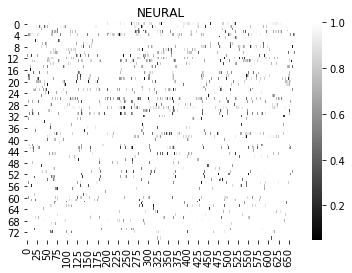

In [68]:
sns.heatmap(1 - data['NEURAL'], cmap='gray').set_title('NEURAL');

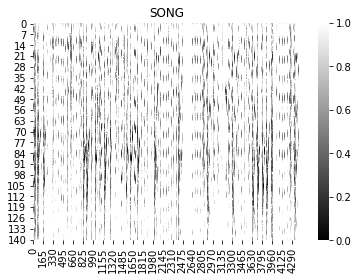

In [69]:
sns.heatmap(1 - data['SONG'], cmap='gray').set_title('SONG');